In [1]:
# https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=HMqQTafXEaei

In [2]:
!nvidia-smi

Tue Jun  6 12:19:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:1B:00.0 Off |                  N/A |
| 40%   48C    P2   111W / 350W |  18829MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:3E:00.0 Off |                  N/A |
| 37%   

In [5]:
from transformers import  get_linear_schedule_with_warmup, RobertaTokenizerFast, RobertaPreTrainedModel, RobertaConfig, RobertaModel
from pylab import rcParams
import re, os
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from datetime import datetime


%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 10, 6

In [6]:
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 32
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
current_time = datetime.now().strftime("%Y%m%d-%I_%M%p")
outFilepath = 'out/substance_classifier/' + device.type + current_time +'/'
try:
    os.makedirs(outFilepath)
except FileExistsError:
    pass
outFilepath

'out/substance_classifier/cuda20230606-12_19PM/'

In [7]:
df =pd.read_csv('/data/jmharja/projects/robertaForTweetAnalysis/input/Tweets_Spring_Summer_2021_coded.csv',
                      lineterminator='\n', skipinitialspace=True, usecols= ['Tweet', 'Substance', 'Use', 'Intent'])
# # in the tweets find the hashtag & mentions
# df['hashTags'] = df['Tweet'].str.findall("#(\w+)")
# df['mentions'] = df['Tweet'].str.findall("@(\w+)")
# # Remove hashtag and mentions
# df['Tweet'] = df['Tweet'].str.replace(r'#(\w+)', '', regex=True)
# df['Tweet'] = df['Tweet'].str.replace(r'@(\w+)', '', regex=True)
df

,Tweet,Substance,Use,Intent
0,@aaronaxline @friskycarolina was livid to watc...,X,X,X
1,anyways. im starting my diet on Sunday. i was ...,A,S,A
2,Alcohol and drugs is good for the mind but not...,D,S,A
3,"Now that's jus sad 😂 #BuckeyeNation""62% of Ohi...",X,X,X
4,Bro do you ever get in those moods where you j...,X,X,X
...,...,...,...,...
4462,How much coke she did no wonder age OD'd. Damn.,C,S,X
4463,Ain't no salary cap in the dope game ain't no ...,C,X,X
4464,Aw man they busting out the nose candy &amp; f...,C,N,A
4465,They say crack kill nigga my crack sell #21Savage,C,X,X


Text(0.5, 0, 'Substance types')

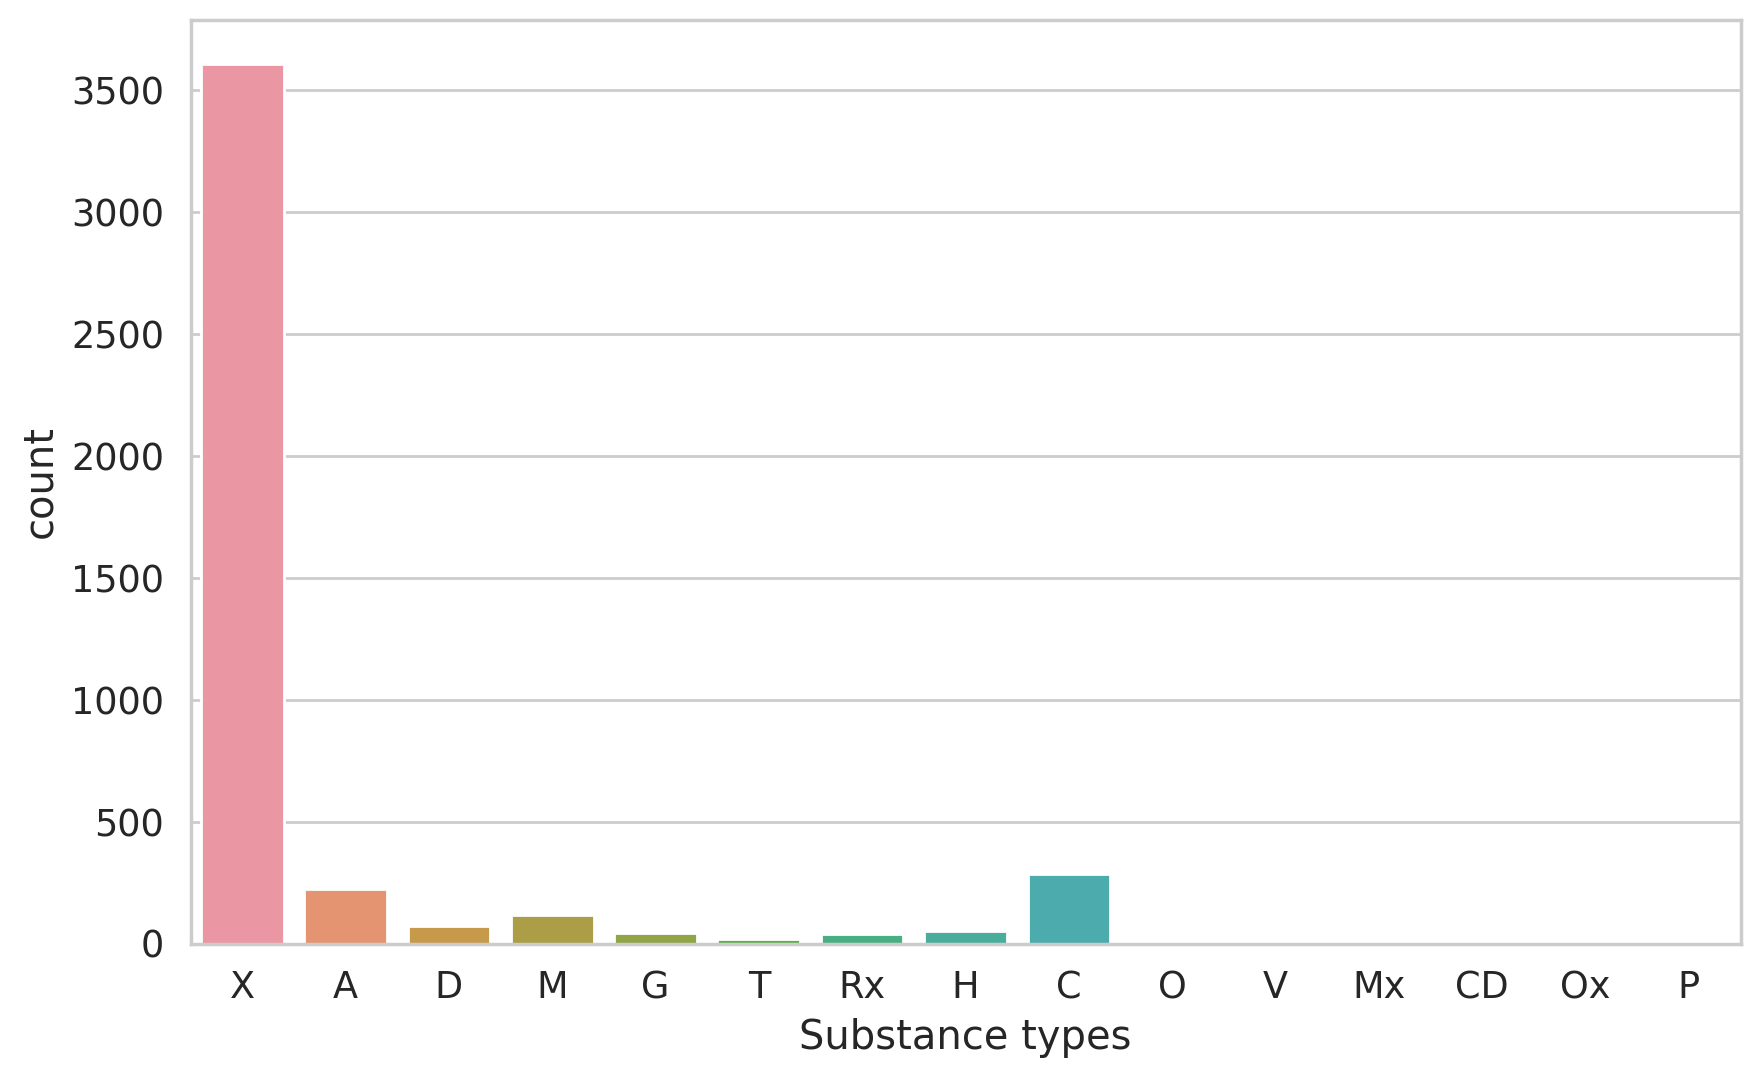

In [8]:
sns.countplot(x = df['Substance'])
plt.xlabel('Substance types')

In [9]:
class_names = {'X':'Unclear', 'D': 'Multiple identified specific substances', 'A':'Alcohol', 'M':'Marijuana', 'T':'Tobacco', 'V':'Vape', 
               'C':'Cocaine', 'G':'Indeterminiate and or generic dec indicative of substance type(s)', 'H':'Heroine'}
possible_labels = df.Substance.unique()
print('Unique Labels', possible_labels.size)
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
df['label'] = df.Substance.replace(label_dict)
df

Unique Labels 15


,Tweet,Substance,Use,Intent,label
0,@aaronaxline @friskycarolina was livid to watc...,X,X,X,0
1,anyways. im starting my diet on Sunday. i was ...,A,S,A,1
2,Alcohol and drugs is good for the mind but not...,D,S,A,2
3,"Now that's jus sad 😂 #BuckeyeNation""62% of Ohi...",X,X,X,0
4,Bro do you ever get in those moods where you j...,X,X,X,0
...,...,...,...,...,...
4462,How much coke she did no wonder age OD'd. Damn.,C,S,X,8
4463,Ain't no salary cap in the dope game ain't no ...,C,X,X,8
4464,Aw man they busting out the nose candy &amp; f...,C,N,A,8
4465,They say crack kill nigga my crack sell #21Savage,C,X,X,8


# DATA PREPROCESSING

In [10]:
tokenizer_folder = '/data/jmharja/projects/robertaForTweetAnalysis/output/oct2022/TokRoBERTa'
tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_folder, max_len=MAX_LEN)

In [11]:
class Tweet_DataSet(Dataset):
   def __init__(self, data, tokenizer, max_len):
    self.data = data
    self.data['Tweet'] = self.data['Tweet'].map(lambda x: self.cleaner(x))
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  
   def __len__(self):
    return len(self.data)

   def cleaner(self, tweet):
#         print(tweet)
        tweet = re.sub("@[A-Za-z0-9]+","", tweet) #Remove @ sign
        tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
        tweet = " ".join(tweet.split())
        #     tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
        #     tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
        #     tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
        #          if w.lower() in words or not w.isalpha())
        return tweet
    
        
  
   def __getitem__(self, index:int):
    data_row = self.data.iloc[index]
    tweet = data_row.Tweet
    labels = data_row['label']
    encoding = tokenizer.encode_plus(tweet,
                                     None,
                                     max_length = MAX_LEN,
                                     truncation=True,
                                     pad_to_max_length=True,
                                     add_special_tokens=True,
                                     padding='max_length',
                                     return_token_type_ids=True)

    return {
      'tweet_text': tweet,
      'input_ids': torch.tensor(encoding.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(encoding.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(encoding.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(labels, dtype=torch.long)
    }

In [12]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((4020, 5), (223, 5), (224, 5))

In [13]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Tweet_DataSet(df, tokenizer, max_len)
  return DataLoader(ds, batch_size, num_workers=4)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [14]:
class TweetModel(RobertaPreTrainedModel):
    def __init__(self, conf, n_classes):
        super(TweetModel, self).__init__(conf)
        self.roberta = RobertaModel.from_pretrained('/data/jmharja/projects/robertaForTweetAnalysis/output/oct2022/RoBERTaMLM/', config=conf)
        self.drop_out = torch.nn.Dropout(0.3)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = torch.nn.Linear(768, n_classes)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.drop_out(pooler)
        output = self.classifier(pooler)
        return output

In [15]:
config = RobertaConfig(
    vocab_size=8192,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)
model = TweetModel(config, len(label_dict))
model = model.to(device)

Some weights of the model checkpoint at /data/jmharja/projects/robertaForTweetAnalysis/output/oct2022/RoBERTaMLM/ were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /data/jmharja/projects/robertaForTweetAnalysis/output/oct2022/RoBERTaMLM/ and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably T

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [17]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    big_val, big_idx = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(big_idx == targets)

    loss = loss_fn(outputs, targets)
    losses.append(loss.item())

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)

In [18]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids)
      _, preds = torch.max(outputs, dim=1)
      correct_predictions += torch.sum(preds == targets)

      loss = loss_fn(outputs, targets)
      losses.append(loss.item())

  return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
FORCE_TRAIN = True
print(40*"*", 'Training')
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')
    
  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), outFilepath +'ckpt.bin')
    best_accuracy = val_acc

**************************************** Training
Epoch 1/32
----------
Train loss 0.7531136174257549 accuracy 0.8323383084577114
Val   loss 0.6032195540943316 accuracy 0.8565022421524664

Epoch 2/32
----------
Train loss 0.44957327986106516 accuracy 0.8962686567164179
Val   loss 0.4925851763359138 accuracy 0.8923766816143498

Epoch 3/32
----------
Train loss 0.3079638732745061 accuracy 0.9266169154228855
Val   loss 0.4445259366184473 accuracy 0.9013452914798206

Epoch 4/32
----------
Train loss 0.22869976058820382 accuracy 0.9432835820895522
Val   loss 0.48207182224307743 accuracy 0.905829596412556

Epoch 5/32
----------
Train loss 0.15517332331768963 accuracy 0.9651741293532338
Val   loss 0.5223363028739446 accuracy 0.905829596412556

Epoch 6/32
----------
Train loss 0.11265500221472596 accuracy 0.9708955223880597
Val   loss 0.5622914763100978 accuracy 0.905829596412556

Epoch 7/32
----------
Train loss 0.08157366266638587 accuracy 0.981592039800995
Val   loss 0.5886878527401548 accu

In [ ]:
# plt.plot(history['train_acc'], label='train accuracy')
# plt.plot(history['val_acc'], label='validation accuracy')

# plt.title('Training history')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
test_acc.item()

# Prediction

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
      _, preds = torch.max(outputs, dim=1)
      probs = torch.nn.functional.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_tweets, y_pred, y_pred_probs, y_test = get_predictions(model, val_data_loader)

In [ ]:
y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
someListOfLists = list(zip(y_tweets, y_test.numpy(), y_pred.numpy()))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['Tweet', 'Actual', 'Predicted' ])
dff.to_csv(filename + 'val_pred.csv')

In [ ]:
possible_labels_test = df_val.Substance.unique()
print('Train Unique Labels', df_train.Substance.unique())
print('Val Unique Labels', df_val.Substance.unique())
print('Test Unique Labels', df_test.Substance.unique())

In [ ]:
print(classification_report(y_test, y_pred, target_names=possible_labels_test))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=possible_labels_test, columns=possible_labels_test)
show_confusion_matrix(df_cm)

In [ ]:
idx = 77

review_text = y_tweets[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({'class_names': possible_labels,'values': y_pred_probs[idx]})
true_sentiment, y_pred[idx]
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {possible_labels[true_sentiment]}')
print(f'True sentiment category fullname: {class_names[possible_labels[true_sentiment]]}')
# sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
# plt.ylabel('Substance Type')
# plt.xlabel('probability')
# plt.xlim([0, 1]);

In [ ]:
df3 =pd.read_csv('/data/jmharja/projects/robertaForTweetAnalysis/input/ReviewedPrediction_1.csv',lineterminator='\n', skipinitialspace=True,)
df3_pos= df3.loc[df3['label']==1]
df3_neg = df3.loc[df3['label']==0]
df3_neg.shape, df3_pos.shape

In [ ]:
# df3_pos = df3_pos.drop(df3_pos.columns[[1]], axis=1).copy()
pred_data_loader = create_data_loader(df3_pos, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
y_tweets, y_pred, y_pred_probs, y_test = get_predictions(model, pred_data_loader)

In [ ]:
y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
someListOfLists = list(zip(y_tweets, y_test.numpy(), y_pred.numpy()))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['Tweet', 'Actual', 'Predicted' ])
# dff.drop(dff.columns[['Actual']], axis=1).copy()
dff.to_csv('out/pred_res_'+ filename + '.csv')